Copyright 2022 Natasha A. Sahr, Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.


# Ridge and Lasso Regression: L1 and L2 penalization

## Regularization

Up to this point, we've focused on relatively small numbers of predictors in our models.
When we have datasets with large numbers of predictors, we need to think about new techniques to deal with the additional complexity.
Part of the reason is that our highly manual methods no longer scale well.
Imagine if you had to make and evaluate plots for 1000 variables!
The other part is that once we have many variables, the chances of them interacting with each other in very complicated ways gets increasingly larger.

We talked about one "bad" kind of interaction before, multicolinearity.
Multicolinearity occurs when two variables mostly measure the same thing.
The problem with multicolinearity in linear models is that the variables involved will no longer have unique solutions for their estimated coefficients.
What this means in practice is that multicolinearity is a small, but manageable problem for small datasets, but multicolinearity becomes a very serious problem for large datasets, at least for linear models, which arguably are the most important models in science.

Today we will talk about two methods that address the complexity of having many variables, including multicolinearity.
Both of these methods use a "big idea" in data science called **regularization**.
The idea behind regularization is that you **penalize** complex models in favor of simpler ones.
These simpler models use fewer variables, making them easier to understand.
If you penalization is set up in the right way, the simpler models can also avoid multicolinearity problems.
Today we will focus on ridge and lasso regression, but it is important to remember that many other models use similar regularization techniques. 
Once you know to look for it, you will start to see it everywhere!

## What you will learn

In the sections that follow, you will learn about ridge and lasso regularization and how they can help us assess a large number of variables in for candidacy in regression models by penalizing variables that don't contribute a large effect in the variability of the outcome. We will study the following:

- Ridge regression with the L2 penalty
- Lasso regression with the L1 penalty
- Assessing model accuracy
- Comparing regularized models 
- Selection of the tuning parameter $\lambda$

## When to use regularization/penalization in regression

Regularization is a general strategy that applies a penalty in the optimization of a regression model. With the correct tuning parameter selection, it will prevent overfitting a model to a particular dataset and improve the potential for generalization to new datasets.
Regularization becomes particularly important in regression where there are large numbers of predictors because it can mitigate multicollinearity and cause shrinkage (for L2) or encourage sparsity (for L1) of the coefficients for variables that contribute less to the prediction of the outcome.

## Vanilla logistic regression

Let's start by applying logistic regression to some breast cancer data.
This model will serve as a baseline for comparison to the ridge and lasso models that come later.
We're going to get the breast cancer data from `sklearn` instead of loading a CSV.
Libraries like `sklearn` frequently come with their own datasets for demonstration purposes.

### Load data

The [data](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|
| class | Nominal (binary) | malignant (1) or benign (0)

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI Machine Learning Repository library
    </a>
</div>
<br>

We want to predict the presence/absence of cancer, so it makes sense to use logistic regression rather than linear regression.
Ridge and lasso penalties work the same way in both kinds of regression.

Start by loading `readr` and `dplyr` so we can read data into a dataframe and manipulate it:

- `library readr`
- `library dplyr`

In [50]:
library(readr)
library(dplyr)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable></variables><block type="import_R" id="q]np1Ju|B`4k*R-zylwU" x="44" y="66"><field name="libraryName" id="_;PP-/]_2fNUR.dyhw(8">readr</field><next><block type="import_R" id="(%@0XC,((6M%4]kj+iDm"><field name="libraryName" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field></block></next></block></xml>

Read the data into a dataframe:
    
- Set `dataframe` to `with readr do read_csv`
    - using `"datasets/cancer.csv"`
- `dataframe` (to display)

In [51]:
dataframe = readr::read_csv("datasets/cancer.csv")

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable></variables><block type="variables_set" id="gM*jw`FfIR3)8=g0iEB7" x="28" y="220"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id=",vaW{t?FHN1~E?+,h!w-"><mutation items="1"></mutation><field name="VAR" id="_;PP-/]_2fNUR.dyhw(8">readr</field><field name="MEMBER">read_csv</field><data>readr:read_csv</data><value name="ADD0"><block type="text" id="dfrpI5b@DHr+DQ:|@vpv"><field name="TEXT">datasets/cancer.csv</field></block></value></block></value></block><block type="variables_get" id="dn{+Q#DO%lN;G_tFGJ#B" x="8" y="304"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></xml>

Rows: 569 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (31): mean radius, mean texture, mean perimeter, mean area, mean smoothn...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0


Because this data is too "easy", we need to make it more complicated to really show the benefits of ridge and lasso.
Remember that multicolinearity is bad? 
Let's make it artificially multicolinear by duplicating the columns in the dataframe so that we have four side by side:

- Set `dataframe2` to 
    - `pipe`
        - `dataframe`
        - to with `dplyr` do `mutate`
            - using `across(.cols=-Target,.names = '{.col}A'`
        - to with `dplyr` do `mutate`
            - using `across(.cols=-Target,.names = '{.col}B'`
- `dataframe2`

*Note: Each `mutate` operates on all columns but `Target`, creating new columns for them and appending a letter at the end. We'll end up with four sets that end with nothing (original), end with A, end with B, and end with AB.*

In [52]:
dataframe2 = dataframe %>%
    dplyr::mutate(across(.cols=-Target,.names = '{.col}A')) %>%
    dplyr::mutate(across(.cols=-Target,.names = '{.col}B'))

dataframe2

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable></variables><block type="variables_set" id="UU4[!?n{BXSs8Trb/zbO" x="-78" y="-57"><field name="VAR" id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</field><value name="VALUE"><block type="pipe_R" id="1mxTAm9oO~0LrDH?nwK2"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="yRqluT.Zz@q*sgyqxv|V"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="#;=o[o@wV!C3Jn/Ud9o]"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">mutate</field><data>dplyr:mutate</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="bk5!$SVjA}/H,euG(Wb`"><field name="CODE">across(.cols=-Target,.names = '{.col}A')</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="(ssP`P=4CGdD|;PU+H{@"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">mutate</field><data>dplyr:mutate</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="`!e,)r6Z1Ao,)Z)#qdcG"><field name="CODE">across(.cols=-Target,.names = '{.col}B')</field></block></value></block></value></block></value></block><block type="variables_get" id="nM2l@R(O_ZrLKxoJME()" x="-92" y="132"><field name="VAR" id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</field></block></xml>

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target,mean radiusA,mean textureA,mean perimeterA,mean areaA,mean smoothnessA,mean compactnessA,mean concavityA,mean concave pointsA,mean symmetryA,mean fractal dimensionA,radius errorA,texture errorA,perimeter errorA,area errorA,smoothness errorA,compactness errorA,concavity errorA,concave points errorA,symmetry errorA,⋯,radius errorB,texture errorB,perimeter errorB,area errorB,smoothness errorB,compactness errorB,concavity errorB,concave points errorB,symmetry errorB,fractal dimension errorB,worst radiusB,worst textureB,worst perimeterB,worst areaB,worst smoothnessB,worst compactnessB,worst concavityB,worst concave pointsB,worst symmetryB,worst fractal dimensionB,mean radiusAB,mean textureAB,mean perimeterAB,mean areaAB,mean smoothnessAB,mean compactnessAB,mean concavityAB,mean concave pointsAB,mean symmetryAB,mean fractal dimensionAB,radius errorAB,texture errorAB,perimeter errorAB,area errorAB,smoothness errorAB,compactness errorAB,concavity errorAB,concave points errorAB,symmetry errorAB,fractal dimension errorAB,worst radiusAB,worst textureAB,worst perimeterAB,worst areaAB,worst smoothnessAB,worst compactnessAB,worst concavityAB,worst concave pointsAB,worst symmetryAB,worst fractal dimensionAB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,⋯,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,⋯,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,19.69,21.25,130.00,1203.0,0

As you can see, we're now working with 120 predictor variables instead of the original 30.
It's a lot more than we'd like to have to examine manually. 

### Explore data

Let's load `base`, `ggplot2`, `psych`, and `corrr` for exploring the data:

- `library base`
- `library ggplot2`
- `library psych`
- `library corrr`

In [53]:
library(corrr)
library(base)
library(ggplot2)
library(psych)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=":}mQPTQxRKZMh,T7NR$$">corrr</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="-%rFagMkPz%VG@$q~ANP">psych</variable></variables><block type="import_R" id="fvM{-l%xz0![2.n:2Hoj" x="-86" y="-4"><field name="libraryName" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><next><block type="import_R" id="*VxvMC/-.UEwASPz(/;T"><field name="libraryName" id="6C!l+@S8,SvtzakmsxQD">base</field><next><block type="import_R" id="n?whQI8t]Qj6)k-ny|GN"><field name="libraryName" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><next><block type="import_R" id="P-VMU%%i=n!?0`h3v|jE"><field name="libraryName" id="-%rFagMkPz%VG@$q~ANP">psych</field></block></next></block></next></block></next></block></xml>

Based on the earlier discussion, you might guess that this dataset has a problem with multicolinearity.
And you'd be right!

Let's make a quick heatmap to show this.
Note we are using the original dataframe because the duplicates we added would confuse things:

- `pipe`
    - `dataframe` 
    - to with `corrr` do `correlate`
    - then to with `corrr` do `rearrange`
    - then to with `corrr` do `shave`
    - then to `make plot`
        - with `corrr` do `rplot`
        - with  `ggplot2` do `theme`
            - using `axis.text.x = element_text(angle = 60, hjust = 1)`

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


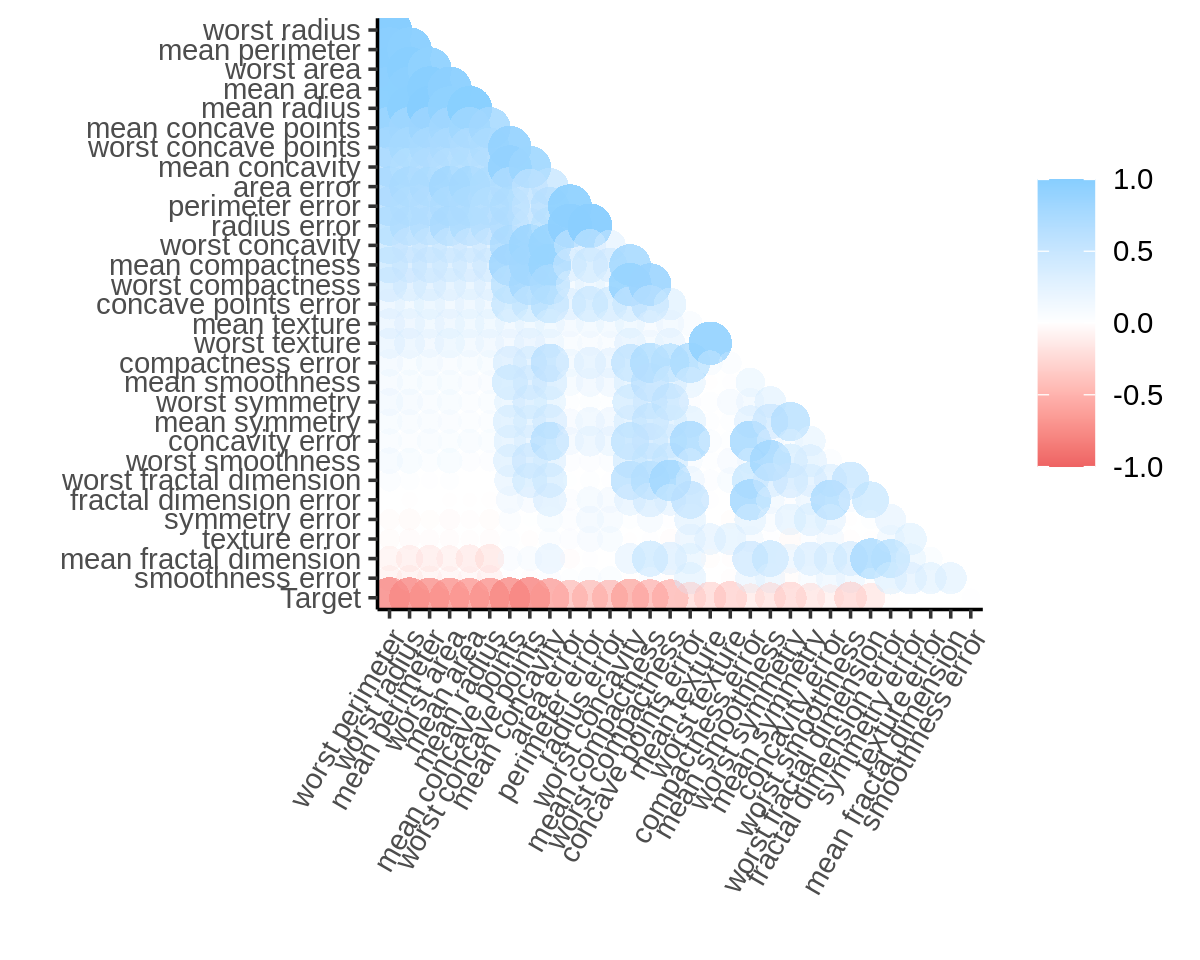

In [54]:
dataframe %>%
    corrr::correlate() %>%
    corrr::rearrange() %>%
    corrr::shave() %>%
    corrr::rplot() +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id=":}mQPTQxRKZMh,T7NR$$">corrr</variable><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable></variables><block type="pipe_R" id="N12|vt`l[nbbEa%Y~#m8" x="-52" y="-175"><mutation items="4"></mutation><value name="INPUT"><block type="variables_get" id="gVhqUlh8Cy^F.8HkQSR$"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="!IGLlvXdM16CaY84=Bg6"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">correlate</field><data>corrr:correlate</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="}:lkTT23H2F#0KMm`|,/"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">rearrange</field><data>corrr:rearrange</data></block></value><value name="ADD2"><block type="varDoMethod_R" id="O/(t7,oDux_+[+q!kGh6"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">shave</field><data>corrr:shave</data></block></value><value name="ADD3"><block type="ggplot_plus_R" id="3ilR0aqrIo(uJr*!6bpU"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="=#E:Zp_ck$*)mk/i8`^K"><mutation items="1"></mutation><field name="VAR" id=":}mQPTQxRKZMh,T7NR$$">corrr</field><field name="MEMBER">rplot</field><data>corrr:rplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="f#R*ao;9?HYu9{XmEY3r"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="@ce!p}8ffHehsPmXP[bV"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></value></block></xml>

In terms of predicting the `Target`, we see that many features negatively correlate with it, which should help with prediction.

However, even in the original dataset, many features are highly positively correlated with each other.
The largest grouping of these is in the top left of the plot, and interestingly these same features are most negatively correlated (and thus predictive) of `Target`.

## Prepare train/test sets

We need to split the dataframe into training data and testing data.

First, load the package for splitting and a package for removing NA rows:

- `library rsample`
- `library tidyr`

In [55]:
library(rsample)
library(tidyr)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable></variables><block type="import_R" id="g^doBJYp/fk!)^uuYnUf" x="-280" y="10"><field name="libraryName" id="~~-I(f=60)#JfKGvV_AP">rsample</field><next><block type="import_R" id="?6P$ZRn,T9@[Q~MNpW?d"><field name="libraryName" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field></block></next></block></xml>

Now split the data, but first convert `Target` to factor, which is a requirement of the model, and drop rows with NA.

Also specify a **random seed** so your results match mine.
A random seed lets us synchronize our random number generators.

- Set `dataframe2` to 
    - `pipe`
        - `dataframe2`
        - to with `dplyr` do `mutate`
            - using `Target=factor(Target)`
        - to with `tidyr` do `drop_na`
            
- with `base` do `set.seed` using `2`

- Set `data_split` to `with rsample do initial split`
    - using `dataframe2`
    - and `prop=.80`
- Set `data_train` to `with rsample do training`
    - using `data_split`
- Set `data_test` to `with rsample do testing`
    - using `data_split`
- `data_train`


In [56]:
dataframe2 = dataframe2 %>%
    dplyr::mutate(Target=factor(Target)) %>%
    tidyr::drop_na()

base::set.seed(2)

data_split = rsample::initial_split(dataframe2,prop=.80)
data_train = rsample::training(data_split)
data_test = rsample::testing(data_split)

data_train

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="bQ!4E:J!~]0(]7KV]m@=">data_split</variable><variable id=":iMr},W7(N7vSLAUw!ao">data_train</variable><variable id="~~-I(f=60)#JfKGvV_AP">rsample</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="pqe,bA|(visJQd48=Wf~" x="-123" y="58"><field name="VAR" id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</field><value name="VALUE"><block type="pipe_R" id="KA=hLd3r{UKxA_qN8jzu"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="qw7eF};{$f3x1Rr0U6gS"><field name="VAR" id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="-00s4E.d(nD9%clg}Wi%"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">mutate</field><data>dplyr:mutate</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="GBV01=On`usB9nUSdhBA"><field name="CODE">Target=factor(Target)</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="QEb;*oCDqheR}$/ePZxm"><mutation items="1"></mutation><field name="VAR" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field><field name="MEMBER">drop_na</field><data>tidyr:drop_na</data></block></value></block></value></block><block type="varDoMethod_R" id="Bs.?L_yk:!JU:!D9$e:2" x="-107" y="198"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">set.seed</field><data>base:set.seed</data><value name="ADD0"><block type="math_number" id="y3|#H:ii-(np[L}nH,7)"><field name="NUM">2</field></block></value></block><block type="variables_set" id="s!g),aa^(]dox/f`@P!y" x="-116" y="313"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field><value name="VALUE"><block type="varDoMethod_R" id="hPsr6}9C/VNgaLsKuR,o"><mutation items="2"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">initial_split</field><data>rsample:initial_split</data><value name="ADD0"><block type="variables_get" id="]~#@ltf];dTom_%pzV4n"><field name="VAR" id="9!`e7J$K:A*o3;@Jx]|c">dataframe2</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="R`?vH79hsA6Duxa9)AFX"><field name="CODE">prop=.80</field></block></value></block></value><next><block type="variables_set" id="3J6#JDFV0wE?V;NuM=?L"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field><value name="VALUE"><block type="varDoMethod_R" id="X|Q7lj,pD_9W{%^.xd7h"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">training</field><data>rsample:training</data><value name="ADD0"><block type="variables_get" id="JFCmHyJPiN`qwnlE~:iT"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value><next><block type="variables_set" id="Y]ag(g~}tkN6:_X*]6P{"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field><value name="VALUE"><block type="varDoMethod_R" id="WBYo8G|ZcojJAqETRnv`"><mutation items="1"></mutation><field name="VAR" id="~~-I(f=60)#JfKGvV_AP">rsample</field><field name="MEMBER">testing</field><data>rsample:testing</data><value name="ADD0"><block type="variables_get" id="p^~x9|Zj((6qaUVvj#.E"><field name="VAR" id="bQ!4E:J!~]0(]7KV]m@=">data_split</field></block></value></block></value></block></next></block></next></block><block type="variables_get" id="9j){6[r67+7OFx`a~K[Y" x="-115" y="515"><field name="VAR" id=":iMr},W7(N7vSLAUw!ao">data_train</field></block></xml>

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target,mean radiusA,mean textureA,mean perimeterA,mean areaA,mean smoothnessA,mean compactnessA,mean concavityA,mean concave pointsA,mean symmetryA,mean fractal dimensionA,radius errorA,texture errorA,perimeter errorA,area errorA,smoothness errorA,compactness errorA,concavity errorA,concave points errorA,symmetry errorA,⋯,radius errorB,texture errorB,perimeter errorB,area errorB,smoothness errorB,compactness errorB,concavity errorB,concave points errorB,symmetry errorB,fractal dimension errorB,worst radiusB,worst textureB,worst perimeterB,worst areaB,worst smoothnessB,worst compactnessB,worst concavityB,worst concave pointsB,worst symmetryB,worst fractal dimensionB,mean radiusAB,mean textureAB,mean perimeterAB,mean areaAB,mean smoothnessAB,mean compactnessAB,mean concavityAB,mean concave pointsAB,mean symmetryAB,mean fractal dimensionAB,radius errorAB,texture errorAB,perimeter errorAB,area errorAB,smoothness errorAB,compactness errorAB,concavity errorAB,concave points errorAB,symmetry errorAB,fractal dimension errorAB,worst radiusAB,worst textureAB,worst perimeterAB,worst areaAB,worst smoothnessAB,worst compactnessAB,worst concavityAB,worst concave pointsAB,worst symmetryAB,worst fractal dimensionAB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11.61,16.02,75.46,408.2,0.10880,0.11680,0.07097,0.044970,0.1886,0.06320,0.2456,0.7339,1.667,15.89,0.005884,0.02005,0.02631,0.013040,0.01848,0.001982,12.64,19.67,81.93,475.7,0.14150,0.2170,0.2302,0.11050,0.2787,0.07427,1,11.61,16.02,75.46,408.2,0.10880,0.11680,0.07097,0.044970,0.1886,0.06320,0.2456,0.7339,1.667,15.89,0.005884,0.02005,0.02631,0.013040,0.01848,⋯,0.2456,0.7339,1.667,15.89,0.005884,0.02005,0.02631,0.013040,0.01848,0.001982,12.64,19.67,81.93,475.7,0.14150,0.2170,0.2302,0.11050,0.2787,0.07427,11.61,16.02,75.46,408.2,0.10880,0.11680,0.07097,0.044970,0.1886,0.06320,0.2456,0.7339,1.667,15.89,0.005884,0.02005,0.02631,0.013040,0.01848,0.001982,12.64,19.67,81.93,475.7,0.14150,0.2170,0.2302,0.11050,0.2787,0.07427
11.06,14.83,70.31,378.2,0.07741,0.04768,0.02712,0.007246,0.1535,0.06214,0.1855,0.6881,1.263,12.98,0.004259,0.01469,0.01940,0.004168,0.01191,0.003537,12.68,20.35,80.79,496.7,0.11200,0.1879,0.2079,0.05556,0.2590,0.09158,1,11.06,14.83,70.31,378.2,0.07741,0.04768,0.02712,0.007246,0.1535,0.06214,0.1855,0.6881,1.263,12.98,0.004259,0.01469,0.01940,0.004168,0.01191,⋯,0.1855,0.6881,1.263,12.98,0.004259,0.01469,0.01940,0.004168,0.01191,0.003537,12.68,20.35,80.79,496.7,0.11200,0.1879,0.2079,0.05556,0.2590,0.09158,11.06,14.83,70.31,378.2,0.07741,0.04768,0.02712,0.007246,0.1535,0.06214,0.1855,0.6881,1.263,12.98,0.004259,0.01469,0.01940,0.004168,0.01191,0.003537,12.68,20.35,80.79,496.7,0.11200,0.1879,0.2079,0.05556,0.2590,0.09158
18.81,19.98,120.90,1102.0,0.08923,0.05884,0.08020,0.058430,0.1550,0.04996,0.3283,0.8280,2.363,36.74,0.007571,0.01114,0.02623,0.014630,0.01930,0.001676,19.96,24.30,129.00,1236.0,0.12430,0.1160,0.2210,0.12940,0.2567,0.05737,0,18.81,19.98,120.90

### Model 1: Logistic regression

Let's do something we already suspect is not a great idea: regular logistic regression.

First, load the `recipes` and `workflows` packages, along with `parsnip`, `generics`, `hardhat`, and `broom`:

- `library recipes`
- `library workflows`
- `library parsnip`
- `library generics`
- `library hardhat`
- `library broom`

In [57]:
library(recipes)
library(workflows)
library(generics)
library(parsnip)
library(hardhat)
library(broom)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="Ubl?FFCN5uCFfCTQ?7:z">broom</variable></variables><block type="import_R" id="EGE;dT.cnN,o}Y[99#Qb" x="-12" y="8"><field name="libraryName" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><next><block type="import_R" id="6DrE-26ByLD$vC}QeW:}"><field name="libraryName" id="haMDnc8Uj|EjY^608!;]">workflows</field><next><block type="import_R" id="hQ4(=]9%QB3(VWqs9OK:"><field name="libraryName" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><next><block type="import_R" id="d1vIIBH:{ygkVLV/Ts5l"><field name="libraryName" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><next><block type="import_R" id="vFfUgs[O$$~/VO1yVa~v"><field name="libraryName" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><next><block type="import_R" id="cegz.xTQ~Bq[q~wqZQHD"><field name="libraryName" id="Ubl?FFCN5uCFfCTQ?7:z">broom</field></block></next></block></next></block></next></block></next></block></next></block></xml>

#### Training

Let's make a workflow to predict `label` using logistic regression, with a step that scales the predictors (here called normalization).
<!-- We also need a step that makes `label` a factor, as this is required by the model. -->


- Set `recipe` to 
    - `pipe` with `recipes` do `recipe`
        - using `Target ~ .`
        - and `data = data_train`
    - to with `recipes` do `step_normalize`
        - using with `recipes` do `all_numeric_predictors`
        
<!--     - to with `recipes` do `step_num2factor`
        - using `label`
        - and `levels = c("1","0")`
        - and `transform = function(x) x+1` -->
        
- Set `model` to 
    - `pipe` with `parsnip` do `logistic_reg` 
    - to with `parsnip` do `set_mode` 
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"glm"`
- Set `workflow` to 
    - `pipe` with `workflows` do `workflow`
    - to with `workflows` do `add_model`
        - using `model`
    - then to with `workflows` do `add_recipe` 
        - using `recipe`
  
<!-- *Note: We could have loaded `label` as a factor or converted outside the workflow.* -->

In [58]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg() %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glm")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="67" y="169"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="4GS=rm//,9|E^?oX.CVv"><mutation items="0"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glm</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value></block></next></block></next></block></xml>

Fit the workflow:

-  Set `model_logistic` to with `generics` do `fit`
    - using `workflow`
    - and `data = data_train`
`model_logistic`

In [59]:
model_logistic = generics::fit(workflow,data = data_train)

model_logistic

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="mUJO(eHC#vAuFf/{6!C9">model_logistic</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable></variables><block type="variables_set" id="6F5Ls%m;fDN%1P.HL;~b" x="71" y="186"><field name="VAR" id="mUJO(eHC#vAuFf/{6!C9">model_logistic</field><value name="VALUE"><block type="varDoMethod_R" id="jAjgrG@)Vv]=~@dnuh7H"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="variables_get" id="KB;+aD=xFzgUg0(`:xP:"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="siA`Xs!U2c1Ww}6ggh90"><field name="CODE">data = data_train</field></block></value></block></value></block><block type="variables_get" id="qJ0nFc9Y6f9.~_a8X@r6" x="76" y="309"><field name="VAR" id="mUJO(eHC#vAuFf/{6!C9">model_logistic</field></block></xml>

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:  stats::glm(formula = ..y ~ ., family = stats::binomial, data = data)

Coefficients:
                (Intercept)                `mean radius`  
                 -5.322e+46                    3.920e+48  
             `mean texture`             `mean perimeter`  
                  2.018e+46                   -4.552e+48  
                `mean area`            `mean smoothness`  
                  2.881e+47                    6.452e+44  
         `mean compactness`             `mean concavity`  
                  1.234e+47                    2.176e+47  
      `mean concave points`              `mean symmetry`  
                 -9.041e+46                    1.008e+4

Now we can use `augment` to get predicted classes on the test data:


- Set `data_evaluation_logistic` to with `generics` do `augment`
    - `model_logistic`
    - `data_test`
- `data_evaluation_logistic`

In [60]:
data_evaluation_logistic = generics::augment(model_logistic,data_test)

data_evaluation_logistic

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="mUJO(eHC#vAuFf/{6!C9">model_logistic</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="7OSm@|dWOrh4sI}i|5zU" x="-188" y="87"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field><value name="VALUE"><block type="varDoMethod_R" id="/V-=f8y|WOLHmMCx.011"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="(-yLq*8u.=fnYZQx|}dp"><field name="VAR" id="mUJO(eHC#vAuFf/{6!C9">model_logistic</field></block></value><value name="ADD1"><block type="variables_get" id="k4SaVdD8uR0WT{@2b.xL"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field></block></value></block></value></block><block type="variables_get" id="OI3EYMFqtCofk(0Ma~i+" x="-177" y="283"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></xml>

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target,mean radiusA,mean textureA,mean perimeterA,mean areaA,mean smoothnessA,mean compactnessA,mean concavityA,mean concave pointsA,mean symmetryA,mean fractal dimensionA,radius errorA,texture errorA,perimeter errorA,area errorA,smoothness errorA,compactness errorA,concavity errorA,concave points errorA,symmetry errorA,⋯,area errorB,smoothness errorB,compactness errorB,concavity errorB,concave points errorB,symmetry errorB,fractal dimension errorB,worst radiusB,worst textureB,worst perimeterB,worst areaB,worst smoothnessB,worst compactnessB,worst concavityB,worst concave pointsB,worst symmetryB,worst fractal dimensionB,mean radiusAB,mean textureAB,mean perimeterAB,mean areaAB,mean smoothnessAB,mean compactnessAB,mean concavityAB,mean concave pointsAB,mean symmetryAB,mean fractal dimensionAB,radius errorAB,texture errorAB,perimeter errorAB,area errorAB,smoothness errorAB,compactness errorAB,concavity errorAB,concave points errorAB,symmetry errorAB,fractal dimension errorAB,worst radiusAB,worst textureAB,worst perimeterAB,worst areaAB,worst smoothnessAB,worst compactnessAB,worst concavityAB,worst concave pointsAB,worst symmetryAB,worst fractal dimensionAB,.pred_class,.pred_0,.pred_1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,⋯,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,1,2.220446e-16
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,⋯,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,1,2.220446e-16
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.1043

The warnings about "rank-deficient fit" are due to the duplication of variables.

#### Evaluation

First load `yardstick` to get performance metrics:

- `library yardstick`

In [61]:
library(yardstick)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="import_R" id="~]m5/PaJhO^)r2YX)!Ko" x="-152" y="-34"><field name="libraryName" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field></block></xml>

To get the accuracy, recall, precision, and F1 for `Target=0`:


- `pipe`
    - `create list with`
        - with `yardstick` do `accuracy`
            - using `data_evaluation_logistic`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `precision`
            - using `data_evaluation_logistic`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `recall`
            - using `data_evaluation_logistic`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `f_meas`
            - using `data_evaluation_logistic`
            - and `truth=Target`
            - and `estimate=.pred_class`
- to with `dplyr` do `bind_rows`

In [62]:
list(yardstick::accuracy(data_evaluation_logistic,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_logistic,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_logistic,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_logistic,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8482143
precision,binary,0.7450980
recall,binary,0.9047619
f_meas,binary,0.8172043


To get accuracy, precision, recall, and F1 for `Target=1`, copy the blocks above but specify `event_level='second'` below.

In [63]:
list(yardstick::accuracy(data_evaluation_logistic,truth=Target,estimate=.pred_class,event_level='second'), yardstick::precision(data_evaluation_logistic,truth=Target,estimate=.pred_class,event_level='second'), yardstick::recall(data_evaluation_logistic,truth=Target,estimate=.pred_class,event_level='second'), yardstick::f_meas(data_evaluation_logistic,truth=Target,estimate=.pred_class,event_level='second')) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="FEyDpNOT+4J?6|sSQ7dS"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="]j!1;#S)M;U9%NY7;X*6"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="SeJ=[7_.|#)RcHQP_*%d"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="xg2v]5aZu7.(`YUErWjr">data_evaluation_logistic</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="pkY/={G*jC,8W/l?i_T_"><field name="CODE">event_level='second'</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8482143
precision,binary,0.9344262
recall,binary,0.8142857
f_meas,binary,0.8702290


## Regression with a Ridge (L2) Penalty

In ridge regression, also known as L2 penalization, the cost function is altered by adding a penalty equivalent to the square of the magnitude of the coefficients. This is equivalent to saying: for some $c > 0$, $\sum_{j=0}^p \beta_j^2 < 0$ for coefficients $\beta_j, j=1,\dots,p$. 

The cost function for ridge regression is

$$\sum_{i=1}^N (y_i-\hat{y_i})^2 = \sum_{i=1}^N (y_i - \sum_{j=0}^p \beta_i x_{ij})^2 + \lambda \sum_{j=0}^p \beta_j^2$$

When $\lambda = 0$, we have is a linear regression model.

The $\lambda$ regularizes the coefficients so the optimization function is penalized if the coefficients are large. This type of penalization leads to coefficients close to, but not exactly, zero. This feature of ridge regression shrinks the coefficients allowing for a reduction of model complexity and multicollinearity.

### Model 2: Logistic ridge regression (penalty=.75)

Adding a ridge penalty is almost *exactly* like the model we did before.
There are a few differences:

- penalty = .75
- mixture = 0
- engine is `glmnet`

The ridge penalty is an l2 penalty (because it's squared) and is specified by `mixture = 0`, because `mixture` blends from ridge (0) to lasso (1).
The `penalty` value is the **amount** of the penalty.

#### Training

To speed things up, we'll create the workflow, fit it, and augment data all in one cell.

- Set `recipe` to 
    - `pipe` with `recipes` do `recipe`
        - using `Target ~ .`
        - and `data = data_train`
    - to with `recipes` do `step_normalize`
        - using with `recipes` do `all_numeric_predictors`        
- Set `model` to 
    - `pipe` with `parsnip` do `logistic_reg` 
        - using `penalty = .75`
        - and `mixture = 0`
    - to with `parsnip` do `set_mode` 
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"glmnet"`
- Set `workflow` to 
    - `pipe` with `workflows` do `workflow`
    - to with `workflows` do `add_model`
        - using `model`
    - then to with `workflows` do `add_recipe` 
        - using `recipe`
-  Set `model_logistic_ridge_75` to with `generics` do `fit`
    - using `workflow`
    - and `data = data_train`
- Set `data_evaluation_logistic_ridge_75` to with `generics` do `augment`
    - `model_logistic_ridge_75`
    - `data_test`

In [64]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg(penalty = .75,mixture = 0) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glmnet")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)
model_logistic_ridge_75 = generics::fit(workflow,data = data_train)
data_evaluation_logistic_ridge_75 = generics::augment(model_logistic_ridge_75,data_test)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="Eja[(mx/LKTi9jYaw-T~">model_logistic_ridge_75</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="-92" y="98"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="4GS=rm//,9|E^?oX.CVv"><mutation items="0"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="(5EIUtG1r[s`nFr6*q_o"><field name="CODE">penalty = .75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="Rz=`aMMZP1!)]onSuI[%"><field name="CODE">mixture = 0</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glmnet</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="uPz?0#f)qaDo*K{v~.T#"><field name="VAR" id="Eja[(mx/LKTi9jYaw-T~">model_logistic_ridge_75</field><value name="VALUE"><block type="varDoMethod_R" id="1k%URX)R$N[Sz+Af]Bp-"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="variables_get" id="EOhqDQRWe?r|ILuJX4/t"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="[_z9jOR|uGR]AC:laZe;"><field name="CODE">data = data_train</field></block></value></block></value><next><block type="variables_set" id="_5S[h.UFv,L8;N3+2uhP"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field><value name="VALUE"><block type="varDoMethod_R" id="G^kD}UQ+AQ+2.6Z*BbT#"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="t(UW+qq9JfeWzk.ROh!O"><field name="VAR" id="Eja[(mx/LKTi9jYaw-T~">model_logistic_ridge_75</field></block></value><value name="ADD1"><block type="variables_get" id="t?9CE.G3ce=.Vv7A|Ig/"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field></block></value></block></value></block></next></block></next></block></next></block></next></block></xml>

#### Evaluation

To get the accuracy, recall, precision, and F1 for `Target=0`, copy the blocks from before, but change `data_evaluation_logistic` to `data_evaluation_logistic_ridge_75` below.

In [65]:
list(yardstick::accuracy(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9732143
precision,binary,1.0000000
recall,binary,0.9285714
f_meas,binary,0.9629630


Now do the same, but use the blocks for `Target=1`.

In [66]:
list(yardstick::accuracy(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::precision(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::recall(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::f_meas(data_evaluation_logistic_ridge_75,truth=Target,estimate=.pred_class,event_level='second')) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="FEyDpNOT+4J?6|sSQ7dS"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="]j!1;#S)M;U9%NY7;X*6"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="SeJ=[7_.|#)RcHQP_*%d"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="brK4]56yVjy}P]u_7(fc">data_evaluation_logistic_ridge_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="pkY/={G*jC,8W/l?i_T_"><field name="CODE">event_level='second'</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9732143
precision,binary,0.9589041
recall,binary,1.0000000
f_meas,binary,0.9790210


The .75 ridge penalty improved F1 by about .10 (which is a huge improvement), and we no longer have warnings about rank deficiency.

### Model 3: Logistic ridge regression (penalty=.25)

This model is the same as model 2 but with a different ridge penalty:

- penalty= .25

#### Training

Copy the blocks from the last model, with the following changes:

- `penalty = .25`
- `model_logistic_ridge_25`
- `data_evaluation_logistic_ridge_25`

*Be careful not to have any `~75` versions of these variables in the workflow!*

In [67]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg(penalty = .25,mixture = 0) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glmnet")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)
model_logistic_ridge_25 = generics::fit(workflow,data = data_train)
data_evaluation_logistic_ridge_25 = generics::augment(model_logistic_ridge_25,data_test)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="-92" y="98"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="4GS=rm//,9|E^?oX.CVv"><mutation items="0"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="(5EIUtG1r[s`nFr6*q_o"><field name="CODE">penalty = .25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="Rz=`aMMZP1!)]onSuI[%"><field name="CODE">mixture = 0</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glmnet</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="uPz?0#f)qaDo*K{v~.T#"><field name="VAR" id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</field><value name="VALUE"><block type="varDoMethod_R" id="1k%URX)R$N[Sz+Af]Bp-"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="variables_get" id="EOhqDQRWe?r|ILuJX4/t"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="[_z9jOR|uGR]AC:laZe;"><field name="CODE">data = data_train</field></block></value></block></value><next><block type="variables_set" id="_5S[h.UFv,L8;N3+2uhP"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field><value name="VALUE"><block type="varDoMethod_R" id="G^kD}UQ+AQ+2.6Z*BbT#"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="t(UW+qq9JfeWzk.ROh!O"><field name="VAR" id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</field></block></value><value name="ADD1"><block type="variables_get" id="t?9CE.G3ce=.Vv7A|Ig/"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field></block></value></block></value></block></next></block></next></block></next></block></next></block></xml>

#### Evaluation

To get the accuracy, recall, precision, and F1 for `Target=0`, copy the blocks from before, but change the relevant blocks to `data_evaluation_logistic_ridge_25` below.

In [68]:
list(yardstick::accuracy(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9732143
precision,binary,0.9756098
recall,binary,0.9523810
f_meas,binary,0.9638554


Now do the same, but use the blocks for `Target=1`.

In [69]:
list(yardstick::accuracy(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::precision(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::recall(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::f_meas(data_evaluation_logistic_ridge_25,truth=Target,estimate=.pred_class,event_level='second')) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="FEyDpNOT+4J?6|sSQ7dS"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="]j!1;#S)M;U9%NY7;X*6"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="SeJ=[7_.|#)RcHQP_*%d"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="wun}4Z/d$(hc)CZ}+5Nj">data_evaluation_logistic_ridge_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="pkY/={G*jC,8W/l?i_T_"><field name="CODE">event_level='second'</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9732143
precision,binary,0.9718310
recall,binary,0.9857143
f_meas,binary,0.9787234


The .25 ridge penalty is about the same as .75: our F1 on `0` is a bit better, and our F1 on `1` is a bit worse (look at the thousandths place).
Again we no longer have warnings about rank deficiency.

### Comparing Ridge models

Let's plot the coefficients of models 1 to 3 to show the effect of the ridge penalty on the coefficents.
Remember, the penalty *shrinks* coefficients.

Our plotting strategy is to use scatterplots for each model, and unlike previous plots, we'll use a separate data source for each scatterplot.
We'll start with just models 1 and 2 for reasons that will be clear in a moment.

- `make plot` with  `ggplot2` do `ggplot`
    - with  `ggplot2` do `geom_point`
        - using `data = `
            - `pipe`
                - `model_logistic`
                - to with `hardhat` do `extract_fit_parsnip`
                - to with `generics` do `tidy`
        - and `aes(x=term,y=estimate),color="blue"`
    - with  `ggplot2` do `geom_point`
        - using `data = `
            - `pipe`
                - `model_logistic_ridge_25`
                - to with `hardhat` do `extract_fit_parsnip`
                - to with `generics` do `tidy`
        - and `aes(x=term,y=estimate),color="red"`
    - with  `ggplot2` do `theme`
        - using `axis.text.x = element_text(angle = 60, hjust = 1)`


Warning message:
“Removed 90 rows containing missing values (`geom_point()`).”


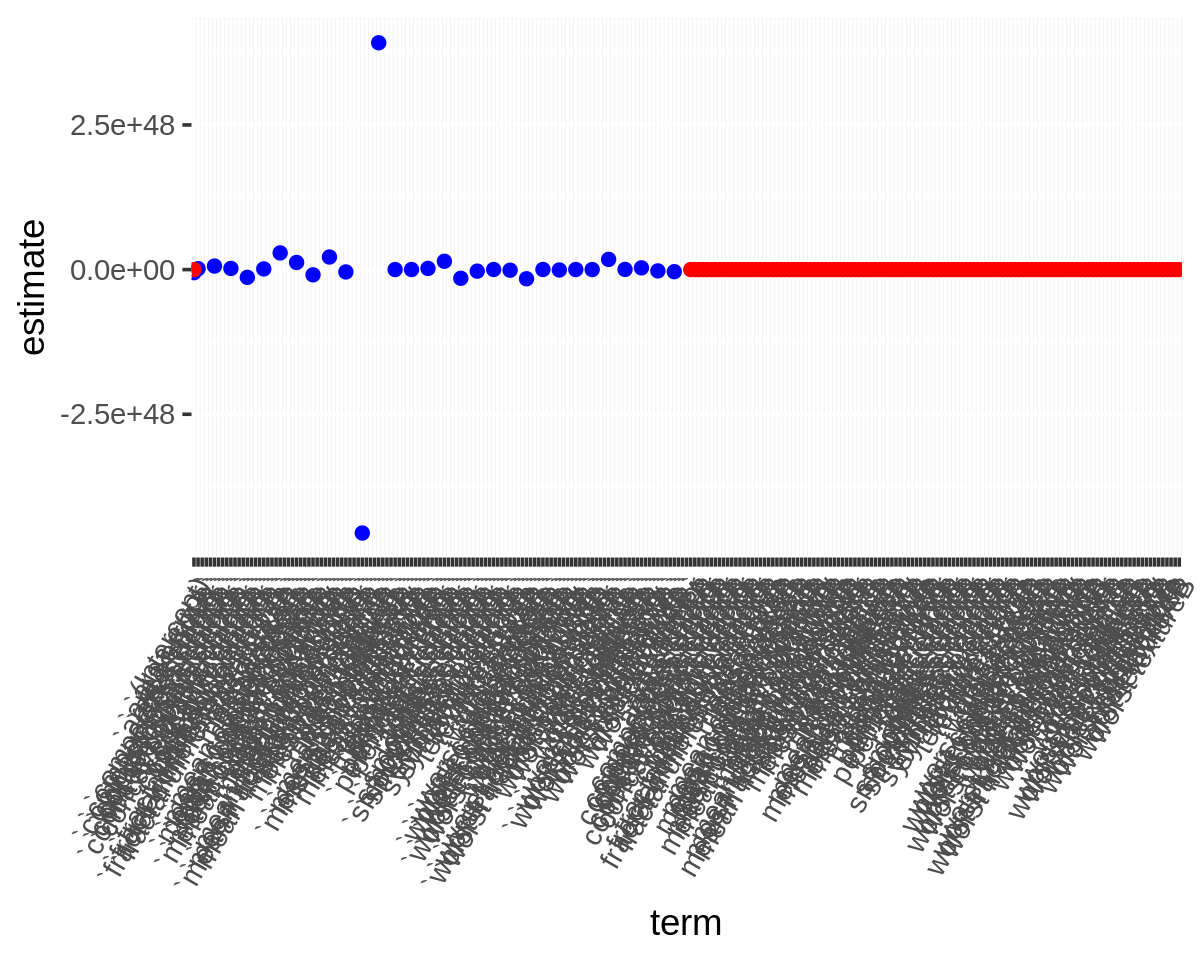

In [82]:
ggplot2::ggplot() +
    ggplot2::geom_point(data= (model_logistic %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="blue") +
    ggplot2::geom_point(data= (model_logistic_ridge_25 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="red") +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="mUJO(eHC#vAuFf/{6!C9">model_logistic</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</variable></variables><block type="ggplot_plus_R" id="6?K!s.FZIsSf$7V4+*v=" x="-225" y="-351"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="eh4ewi+/$?S/}gla~4Z_"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="gB0O=fFwhHF19Lm|z6Dw"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="T0VHC0dWuGSF{Ln$4w.9"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="(P?.8=Q{Lq[tCHdOR?RU"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="O?Ka5.RH6y9e%e!(VB-q"><field name="VAR" id="mUJO(eHC#vAuFf/{6!C9">model_logistic</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="MN6eUb!-b(ZdrMBG_,KB"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="K%yfI6;;npz2b-)ia[AG"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f[PKQ1W~d.bFKn7n)3(t"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="5R+nkj@LdX``sUZDc47@"><field name="CODE">color="blue"</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="i6{3V{1z{p`0Aac*0ZWn"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="gt5vo3hgM`t*%B_K=H#z"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="D.]VVO9=-wGc/aV$*+$4"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="k;*-=#YH{$*N,,Bv]HgO"><field name="VAR" id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="uM3wH[29=c22ahne==.m"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="7grlNgc@9?pd)JdWhVx~"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id=":{}CGA6S6RqO2+zo.S_v"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="w#HCkgqT$DwDw(6vj+FO"><field name="CODE">color="red"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="g|x-O.TEc,u_}T7!5}?,"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=".p:V%Tx89l^r,thgGQRs"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></xml>

The axis labels are too dense to read, but let's ignore that for the moment (there are 4 duplicates of each variable after all).

We can see that the coefficients on the logistic model (blue) have a larger range than the ridge .25 model (red), which essentially appears at zero.
This is the reason we only plotted these two at once - both ridge models are so close to zero that they can't be distinguished at this zoom level.

Copy the blocks above but change `model_logistic` to `model_logistic_ridge_75` and color to orange below.

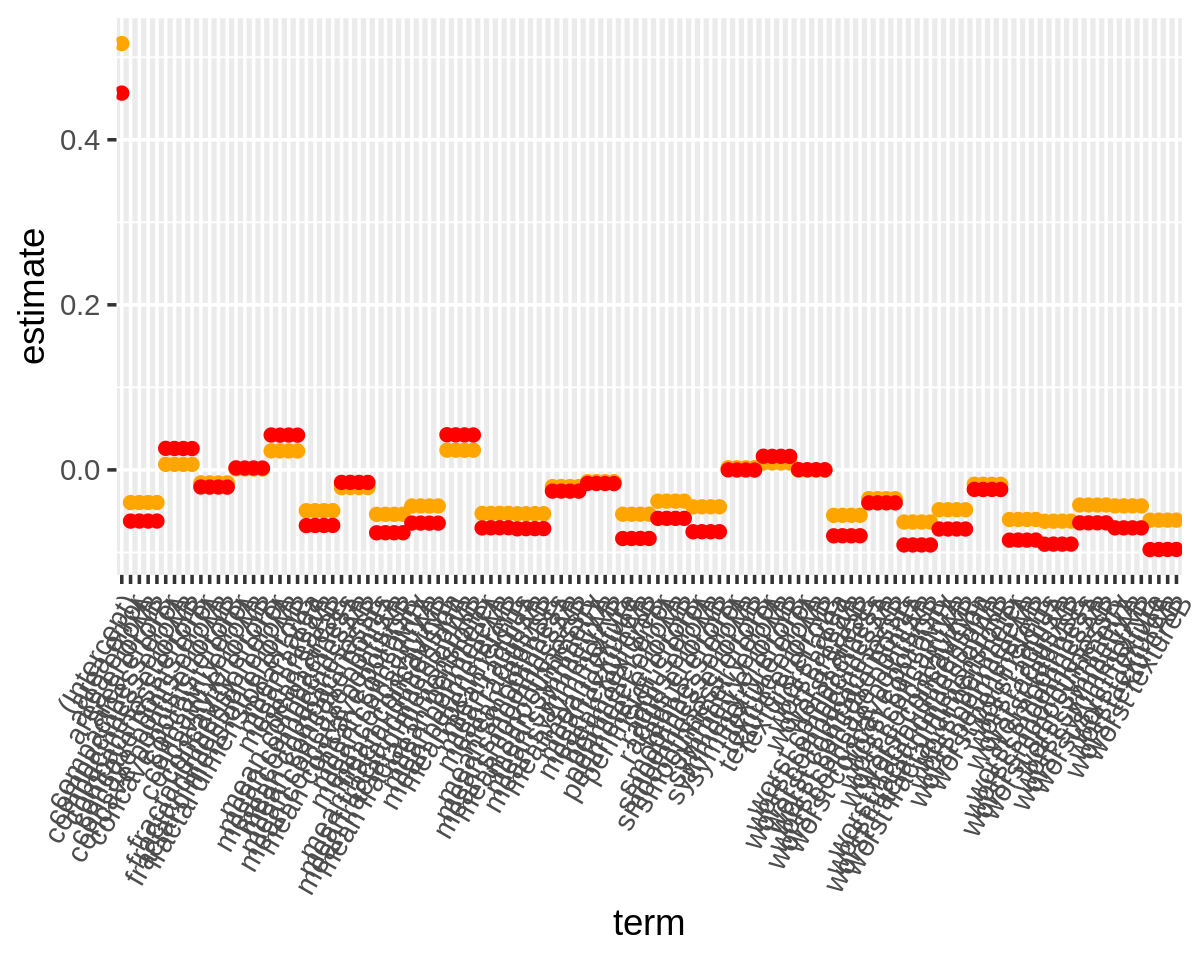

In [84]:
ggplot2::ggplot() +
    ggplot2::geom_point(data= (model_logistic_ridge_75 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="orange") +
    ggplot2::geom_point(data= (model_logistic_ridge_25 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="red") +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="Eja[(mx/LKTi9jYaw-T~">model_logistic_ridge_75</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</variable></variables><block type="ggplot_plus_R" id="6?K!s.FZIsSf$7V4+*v=" x="-225" y="-351"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="eh4ewi+/$?S/}gla~4Z_"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="gB0O=fFwhHF19Lm|z6Dw"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="T0VHC0dWuGSF{Ln$4w.9"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="(P?.8=Q{Lq[tCHdOR?RU"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="O?Ka5.RH6y9e%e!(VB-q"><field name="VAR" id="Eja[(mx/LKTi9jYaw-T~">model_logistic_ridge_75</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="MN6eUb!-b(ZdrMBG_,KB"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="K%yfI6;;npz2b-)ia[AG"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f[PKQ1W~d.bFKn7n)3(t"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="5R+nkj@LdX``sUZDc47@"><field name="CODE">color="orange"</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="i6{3V{1z{p`0Aac*0ZWn"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="gt5vo3hgM`t*%B_K=H#z"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="D.]VVO9=-wGc/aV$*+$4"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="k;*-=#YH{$*N,,Bv]HgO"><field name="VAR" id=":%_R*RK.rXJg6hzQ2OV/">model_logistic_ridge_25</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="uM3wH[29=c22ahne==.m"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="7grlNgc@9?pd)JdWhVx~"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id=":{}CGA6S6RqO2+zo.S_v"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="w#HCkgqT$DwDw(6vj+FO"><field name="CODE">color="red"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="g|x-O.TEc,u_}T7!5}?,"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=".p:V%Tx89l^r,thgGQRs"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></xml>

Now we can see that the ridge .75 (orange) often has larger coefficients than the ridge .25 (red), but not always.
This is not intuitively what we'd expect, though of course the difference between these is penalties is only .5.

## Regression with a Lasso (L1) Penalty

In lasso regression, also known as L1 penalization, the cost function is altered by adding a penalty equivalent to the absolute value of the magnitude of the coefficients. This is equivalent to saying: for some $c > 0$, $|\beta_j| < 0$ for coefficients $\beta_j, j=1,\dots,p$. 

The cost function for lasso regression is

$$\sum_{i=1}^N (y_i-\hat{y_i})^2 = \sum_{i=1}^N (y_i - \sum_{j=0}^p \beta_i x_{ij})^2 + \lambda \sum_{j=0}^p |\beta_j|$$

When $\lambda = 0$, we have is a linear regression model.

The $\lambda$ regularizes the coefficients so the optimization function is penalized if the coefficients are large. This type of penalization leads to exactly zero coefficients. This feature of lasso regression shrinks the coefficients allowing for a reduction of model complexity and multicollinearity and allows use to perform feature selection.

### Model 4: Logistic lasso regression (penalty=.75)

Adding a lasso penalty is almost *exactly* like the model we did before.
There are two differences:

- penalty = .75
- mixture = 1

The lasso penalty is an l1 penalty (because it's absolute value). 

#### Training

Copy the blocks from the last model, with the following changes:

- `penalty = .75`
- `mixture = 1`
- `model_logistic_lasso_75`
- `data_evaluation_logistic_lasso_75`

*Be careful not to have any `~25` versions of these variables in the workflow!*

In [86]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg(penalty = .75,mixture = 1) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glmnet")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)
model_logistic_lasso_75 = generics::fit(workflow,data = data_train)
data_evaluation_logistic_lasso_75 = generics::augment(model_logistic_lasso_75,data_test)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="-92" y="98"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="4GS=rm//,9|E^?oX.CVv"><mutation items="0"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="(5EIUtG1r[s`nFr6*q_o"><field name="CODE">penalty = .75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="Rz=`aMMZP1!)]onSuI[%"><field name="CODE">mixture = 1</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glmnet</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="uPz?0#f)qaDo*K{v~.T#"><field name="VAR" id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</field><value name="VALUE"><block type="varDoMethod_R" id="1k%URX)R$N[Sz+Af]Bp-"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="variables_get" id="EOhqDQRWe?r|ILuJX4/t"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="[_z9jOR|uGR]AC:laZe;"><field name="CODE">data = data_train</field></block></value></block></value><next><block type="variables_set" id="_5S[h.UFv,L8;N3+2uhP"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field><value name="VALUE"><block type="varDoMethod_R" id="G^kD}UQ+AQ+2.6Z*BbT#"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="t(UW+qq9JfeWzk.ROh!O"><field name="VAR" id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</field></block></value><value name="ADD1"><block type="variables_get" id="t?9CE.G3ce=.Vv7A|Ig/"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field></block></value></block></value></block></next></block></next></block></next></block></next></block></xml>

#### Evaluation

To get the accuracy, recall, precision, and F1 for `Target=0`, copy the blocks from before, but change the relevant blocks to `data_evaluation_logistic_lasso_75` below.

In [87]:
list(yardstick::accuracy(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and `NA` will be returned.
Note that 42 true event(s) actually occured for the problematic event level, '0'.”
Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and `NA` will be returned.
Note that 42 true event(s) actually occured for the problematic event level, '0'.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.625
precision,binary,NA
recall,binary,0.000
f_meas,binary,NA


Now do the same, but use the blocks for `Target=1`.

In [88]:
list(yardstick::accuracy(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::precision(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::recall(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class,event_level='second'), yardstick::f_meas(data_evaluation_logistic_lasso_75,truth=Target,estimate=.pred_class,event_level='second')) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="FEyDpNOT+4J?6|sSQ7dS"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="]j!1;#S)M;U9%NY7;X*6"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="SeJ=[7_.|#)RcHQP_*%d"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="N:9khvcDW[/p,kg(;}P_">data_evaluation_logistic_lasso_75</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="pkY/={G*jC,8W/l?i_T_"><field name="CODE">event_level='second'</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6250000
precision,binary,0.6250000
recall,binary,1.0000000
f_meas,binary,0.7692308


The .75 lasso penalty give us perfect recall - we are correctly identifying every case of cancer!
However, we are also falsely detecting cancer that is not there, leasing to lower precision and thus lower F1 than previous models.

### Model 5: Logistic lasso regression (penalty=.25)

This model is the same as model 4 but with a different penalty:

- penalty = .25

#### Training

Copy the blocks from the last model, with the following changes:

- `penalty = .25`
- `mixture = 1`
- `model_logistic_lasso_25`
- `data_evaluation_logistic_lasso_25`

*Be careful not to have any `~75` versions of these variables in the workflow!*

In [89]:
recipe = recipes::recipe(Target ~ .,data = data_train) %>%
    recipes::step_normalize(recipes::all_numeric_predictors())
model = parsnip::logistic_reg(penalty = .25,mixture = 1) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("glmnet")
workflow = workflows::workflow() %>%
    workflows::add_model(model) %>%
    workflows::add_recipe(recipe)
model_logistic_lasso_25 = generics::fit(workflow,data = data_train)
data_evaluation_logistic_lasso_25 = generics::augment(model_logistic_lasso_25,data_test)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Oz8-33unXZJ?3~@*32r-">recipe</variable><variable id="mgo;O)iX^5)A5.@gqIkA">model</variable><variable id="v7B~eW}{zV,n~iX:qTJ-">recipes</variable><variable id="BLc@7E0B7Y3=fus{uzCr">workflow</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</variable><variable id="haMDnc8Uj|EjY^608!;]">workflows</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</variable><variable id="|q$XCeTWL%AdgT|]tbnU">data_test</variable></variables><block type="variables_set" id="w{}j6,P|-6Qepjtz/mj{" x="-92" y="98"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field><value name="VALUE"><block type="pipe_R" id="uzp8+LCnH{r`1Xn%3mdK"><mutation items="1"></mutation><value name="INPUT"><block type="varDoMethod_R" id="U^,K1TWD+}odaY!kExkh"><mutation items="2"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">recipe</field><data>recipes:recipe</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = data_train</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="5=08G^e872=?+){KI?5}"><mutation items="1"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">step_normalize</field><data>recipes:step_normalize</data><value name="ADD0"><block type="varDoMethod_R" id="4GS=rm//,9|E^?oX.CVv"><mutation items="0"></mutation><field name="VAR" id="v7B~eW}{zV,n~iX:qTJ-">recipes</field><field name="MEMBER">all_numeric_predictors</field><data>recipes:all_numeric_predictors</data></block></value></block></value></block></value><next><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">logistic_reg</field><data>parsnip:logistic_reg</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="(5EIUtG1r[s`nFr6*q_o"><field name="CODE">penalty = .25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="Rz=`aMMZP1!)]onSuI[%"><field name="CODE">mixture = 1</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">glmnet</field></block></value></block></value></block></value><next><block type="variables_set" id="f%c#[D)Zv:uHH6WY_TQI"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field><value name="VALUE"><block type="pipe_R" id="Rk~*~r(!3iF+cvcz7IiD"><mutation items="2"></mutation><value name="INPUT"><block type="varDoMethod_R" id="H!7?PcsriTx,;-jJmb`7"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">workflow</field><data>workflows:workflow</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="CrWn^(|[{],FV=/-Jt!b"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_model</field><data>workflows:add_model</data><value name="ADD0"><block type="variables_get" id="7MGIpZZh#XkK`d+ZY4h:"><field name="VAR" id="mgo;O)iX^5)A5.@gqIkA">model</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="L1.O)ZR~Ab`VSER(L}FZ"><mutation items="1"></mutation><field name="VAR" id="haMDnc8Uj|EjY^608!;]">workflows</field><field name="MEMBER">add_recipe</field><data>workflows:add_recipe</data><value name="ADD0"><block type="variables_get" id="U.@@S3Rdx{:xKxE[Fsx]"><field name="VAR" id="Oz8-33unXZJ?3~@*32r-">recipe</field></block></value></block></value></block></value><next><block type="variables_set" id="uPz?0#f)qaDo*K{v~.T#"><field name="VAR" id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</field><value name="VALUE"><block type="varDoMethod_R" id="1k%URX)R$N[Sz+Af]Bp-"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">fit</field><data>generics:fit</data><value name="ADD0"><block type="variables_get" id="EOhqDQRWe?r|ILuJX4/t"><field name="VAR" id="BLc@7E0B7Y3=fus{uzCr">workflow</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="[_z9jOR|uGR]AC:laZe;"><field name="CODE">data = data_train</field></block></value></block></value><next><block type="variables_set" id="_5S[h.UFv,L8;N3+2uhP"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field><value name="VALUE"><block type="varDoMethod_R" id="G^kD}UQ+AQ+2.6Z*BbT#"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="t(UW+qq9JfeWzk.ROh!O"><field name="VAR" id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</field></block></value><value name="ADD1"><block type="variables_get" id="t?9CE.G3ce=.Vv7A|Ig/"><field name="VAR" id="|q$XCeTWL%AdgT|]tbnU">data_test</field></block></value></block></value></block></next></block></next></block></next></block></next></block></xml>

#### Evaluation

To get the accuracy, recall, precision, and F1 for `Target=0`, copy the blocks from before, but change the relevant blocks to `data_evaluation_logistic_lasso_25` below.

In [90]:
list(yardstick::accuracy(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8928571
precision,binary,1.0000000
recall,binary,0.7142857
f_meas,binary,0.8333333


Now do the same, but use the blocks for `Target=1`.

In [91]:
list(yardstick::accuracy(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::precision(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::recall(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class,event_level='second'), yardstick::f_meas(data_evaluation_logistic_lasso_25,truth=Target,estimate=.pred_class,event_level='second')) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="FEyDpNOT+4J?6|sSQ7dS"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="]j!1;#S)M;U9%NY7;X*6"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="SeJ=[7_.|#)RcHQP_*%d"><field name="CODE">event_level='second'</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="4"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="n:(MDJ4el,U6$Q[_/Uw?">data_evaluation_logistic_lasso_25</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock_R" id="pkY/={G*jC,8W/l?i_T_"><field name="CODE">event_level='second'</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8928571
precision,binary,0.8536585
recall,binary,1.0000000
f_meas,binary,0.9210526


The .25 lasso penalty again gives us perfect recall AND slightly better precision so we are not falsely detecting cancer that is not there as much as before.

Although we have lower F1 than the ridge models, this seems like a good model if we feel it is better to falsely diagnose than to miss cancer that is there.

Let's look at how the lasso penalty shrunk some coefficients to zero:

- `pipe`
    - `model_logistic_lasso_25`
    - to with `hardhat` do `extract_fit_parsnip`
    - to with `generics` do `tidy`
    - to with `dplyr` do `filter`
        - using `estimate!=0`

In [96]:
model_logistic_lasso_25 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy() %>%
    dplyr::filter(estimate!=0)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable></variables><block type="pipe_R" id="wOW%V1zWHj{dKgZX0nE}" x="195" y="-59"><mutation items="3"></mutation><value name="INPUT"><block type="variables_get" id="0W2*rlQ3H8[6N_,2{+3E"><field name="VAR" id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</field></block></value><value name="ADD0"><block type="varDoMethod_R" id=",!`Ide3T7c9BtktumWu{"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="XBsws]^r.aQRran0~N3V"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value><value name="ADD2"><block type="varDoMethod_R" id="ONRJZje2;TcI:(@,q/+]"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">filter</field><data>dplyr:filter</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="i!*hO?TiXoN*II:*+.mm"><field name="CODE">estimate!=0</field></block></value></block></value></block></xml>

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),5.072435e-01,0.25
worst perimeter,-2.710095e-01,0.25
worst concave points,-3.630353e-01,0.25
worst concave pointsA,-2.050979e-05,0.25
worst concave pointsB,-6.338789e-15,0.25
worst concave pointsAB,-9.007130e-16,0.25


Only fiver predictors are nonzero, meaning the model set 115 of the coefficients to zero!

This is a great example of how lasso can select variables and remove noise from a model, but even still we can see that four of these are duplicates of each other.

This is thus a great example of how lasso **tends to select correlated groups of variables** where ridge regression does not.

### Comparing Lasso models

As before, let's plot the coefficients of models 1, 4, and 5 to show the effect of the lasso penalty on the coefficients.

Copy the previous blocks and change the models to:

- `model_logistic` in blue
- `model_logistic_lasso_75` in red

Warning message:
“Removed 90 rows containing missing values (`geom_point()`).”


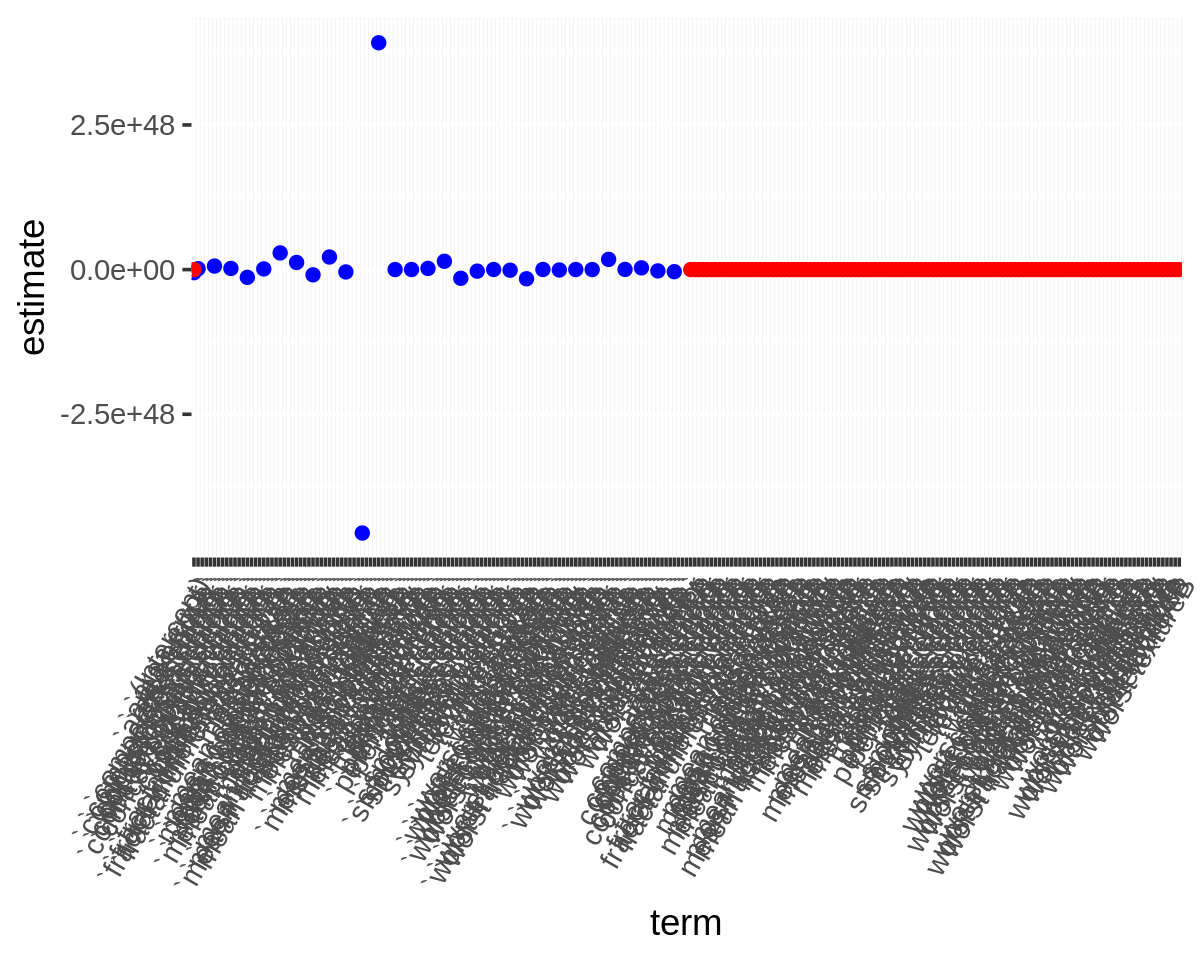

In [97]:
ggplot2::ggplot() +
    ggplot2::geom_point(data= (model_logistic %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="blue") +
    ggplot2::geom_point(data= (model_logistic_lasso_75 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="red") +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="mUJO(eHC#vAuFf/{6!C9">model_logistic</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</variable></variables><block type="ggplot_plus_R" id="6?K!s.FZIsSf$7V4+*v=" x="-225" y="-351"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="eh4ewi+/$?S/}gla~4Z_"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="gB0O=fFwhHF19Lm|z6Dw"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="T0VHC0dWuGSF{Ln$4w.9"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="(P?.8=Q{Lq[tCHdOR?RU"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="O?Ka5.RH6y9e%e!(VB-q"><field name="VAR" id="mUJO(eHC#vAuFf/{6!C9">model_logistic</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="MN6eUb!-b(ZdrMBG_,KB"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="K%yfI6;;npz2b-)ia[AG"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f[PKQ1W~d.bFKn7n)3(t"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="5R+nkj@LdX``sUZDc47@"><field name="CODE">color="blue"</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="i6{3V{1z{p`0Aac*0ZWn"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="gt5vo3hgM`t*%B_K=H#z"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="D.]VVO9=-wGc/aV$*+$4"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="k;*-=#YH{$*N,,Bv]HgO"><field name="VAR" id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="uM3wH[29=c22ahne==.m"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="7grlNgc@9?pd)JdWhVx~"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id=":{}CGA6S6RqO2+zo.S_v"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="w#HCkgqT$DwDw(6vj+FO"><field name="CODE">color="red"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="g|x-O.TEc,u_}T7!5}?,"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=".p:V%Tx89l^r,thgGQRs"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></xml>

As before, we can see the lasso shrunk coefficients a lot.

Copy the previous blocks and change the models to:

- `model_logistic_lasso_25` in orange
- `model_logistic_lasso_75` in red

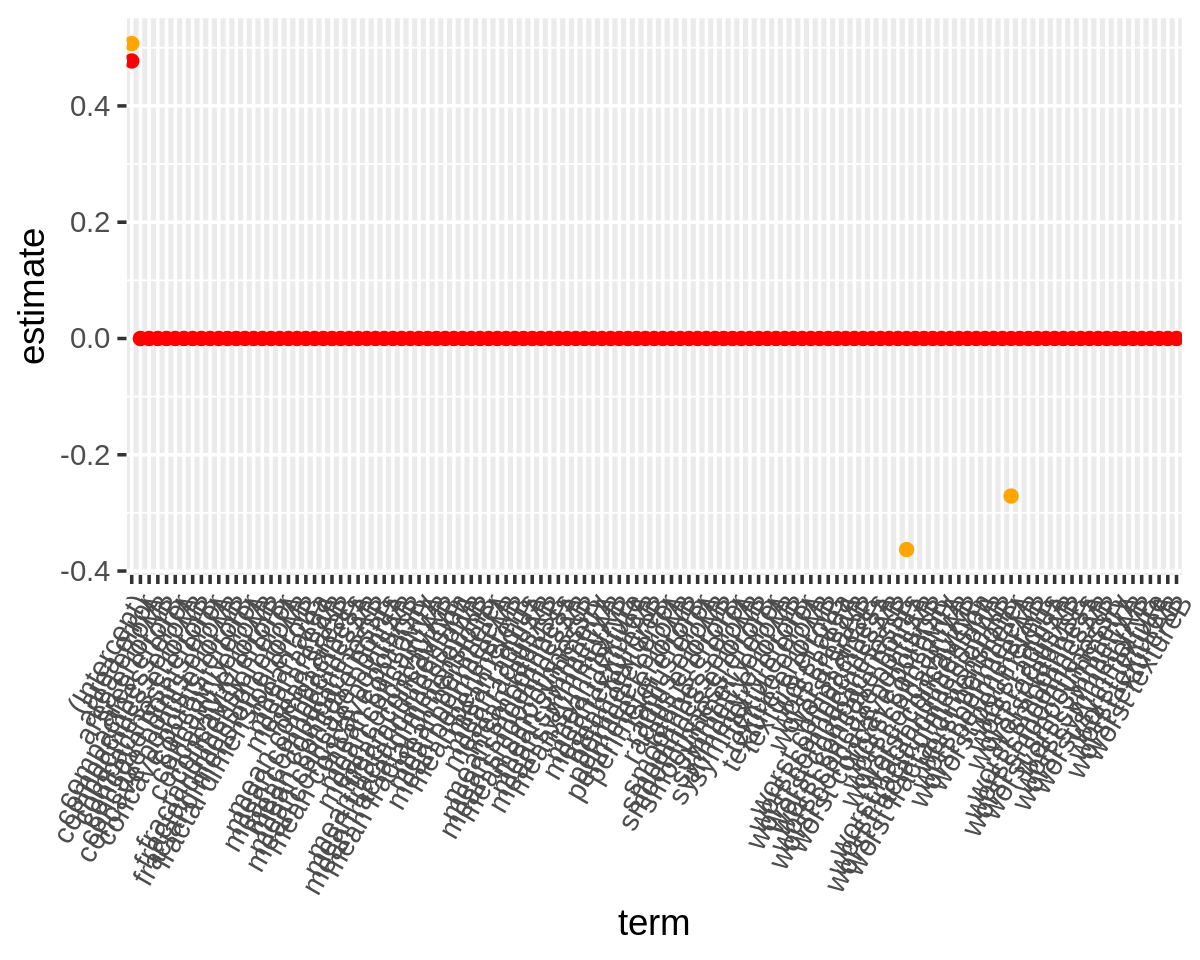

In [98]:
ggplot2::ggplot() +
    ggplot2::geom_point(data= (model_logistic_lasso_25 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="orange") +
    ggplot2::geom_point(data= (model_logistic_lasso_75 %>%
    hardhat::extract_fit_parsnip() %>%
    generics::tidy()),aes(x=term,y=estimate),color="red") +
    ggplot2::theme(axis.text.x = element_text(angle = 60, hjust = 1))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="K2WB)HAgulDnN4.esuaK">ggplot2</variable><variable id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</variable><variable id="{5PU6CE0j[[^yJ79kBMR">hardhat</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</variable></variables><block type="ggplot_plus_R" id="6?K!s.FZIsSf$7V4+*v=" x="-225" y="-351"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="eh4ewi+/$?S/}gla~4Z_"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">ggplot</field><data>ggplot2:ggplot</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="gB0O=fFwhHF19Lm|z6Dw"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="T0VHC0dWuGSF{Ln$4w.9"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="(P?.8=Q{Lq[tCHdOR?RU"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="O?Ka5.RH6y9e%e!(VB-q"><field name="VAR" id="yML_^ej:{)U}2tU+xXG#">model_logistic_lasso_25</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="MN6eUb!-b(ZdrMBG_,KB"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="K%yfI6;;npz2b-)ia[AG"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="f[PKQ1W~d.bFKn7n)3(t"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="5R+nkj@LdX``sUZDc47@"><field name="CODE">color="orange"</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="i6{3V{1z{p`0Aac*0ZWn"><mutation items="3"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">geom_point</field><data>ggplot2:geom_point</data><value name="ADD0"><block type="valueOutputCodeBlock_R" id="gt5vo3hgM`t*%B_K=H#z"><field name="CODE">data=</field><value name="INPUT"><block type="pipe_R" id="D.]VVO9=-wGc/aV$*+$4"><mutation items="2"></mutation><value name="INPUT"><block type="variables_get" id="k;*-=#YH{$*N,,Bv]HgO"><field name="VAR" id=";EH-k45-j|7}J78P$hjh">model_logistic_lasso_75</field></block></value><value name="ADD0"><block type="varDoMethod_R" id="uM3wH[29=c22ahne==.m"><mutation items="1"></mutation><field name="VAR" id="{5PU6CE0j[[^yJ79kBMR">hardhat</field><field name="MEMBER">extract_fit_parsnip</field><data>hardhat:extract_fit_parsnip</data></block></value><value name="ADD1"><block type="varDoMethod_R" id="7grlNgc@9?pd)JdWhVx~"><mutation items="1"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">tidy</field><data>generics:tidy</data></block></value></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id=":{}CGA6S6RqO2+zo.S_v"><field name="CODE">aes(x=term,y=estimate)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="w#HCkgqT$DwDw(6vj+FO"><field name="CODE">color="red"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="g|x-O.TEc,u_}T7!5}?,"><mutation items="1"></mutation><field name="VAR" id="K2WB)HAgulDnN4.esuaK">ggplot2</field><field name="MEMBER">theme</field><data>ggplot2:theme</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=".p:V%Tx89l^r,thgGQRs"><field name="CODE">axis.text.x = element_text(angle = 60, hjust = 1)</field></block></value></block></value></block></xml>

Even a small amount of penalization at .25 removed a lot of variables, and penalization at .75 removed even more.

## Choosing $\lambda$ (AKA C)

As we've seen, different values of the penalty parameter $\lambda$ have different effects on our accuracy and other performance metrics.
So how do we choose  $\lambda$?
There are a number of different methods of finding a **metaparameter** like  $\lambda$, and these methods are fairly general and apply to other problems we've seen before, like choosing the optimal number of clusters or the optimal number of nearest neighbors.
We will revisit this idea in the future, but as a note now `glmnet` computes a range of $\lambda$ internally, making it possible to train a model once rather than repeatedly for different $\lambda$.

<!--  -->